Blatt 09

Aufgabe 1

In [55]:
#a)
import pandas as pd

df = pd.read_csv("pvtest.csv")
df = df[["Time","Edaily", "Dci", "Dcp", "Dcu", "Temp1"]]
df["Time"] = pd.to_datetime(df["Time"])
df["hour"] = df["Time"].dt.hour
df = df.set_index("Time")

df = df.resample("5min").mean()
df = df.ffill()
print(df.head(10))



C:\Users\wessl\AppData\Local\Temp\ipykernel_15476\3319897448.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Time"] = pd.to_datetime(df["Time"])


                     Edaily  Dci  Dcp    Dcu  Temp1  hour
Time                                                     
2021-01-01 07:55:00   0.000  0.0  0.0    0.0    0.0   7.0
2021-01-01 08:00:00   0.000  0.0  0.0    0.0    0.0   8.0
2021-01-01 08:05:00   0.000  0.0  0.0    0.0    0.0   8.0
2021-01-01 08:10:00   0.000  0.0  0.0    0.0    0.0   8.0
2021-01-01 08:15:00   0.000  0.0  0.0    0.0    0.0   8.0
2021-01-01 08:20:00   0.000  0.0  0.0    0.0    0.0   8.0
2021-01-01 08:25:00   0.000  0.0  0.0    0.0    0.0   8.0
2021-01-01 08:30:00   0.000  0.0  0.0   75.0    2.0   8.0
2021-01-01 08:35:00   0.001  0.0  0.0  252.0    8.0   8.0
2021-01-01 08:40:00   0.002  0.0  0.0  251.0    8.0   8.0


In [56]:
#b Train/Test-Split
from math import ceil

end_train = ceil(len(df) * 0.9)
df_train = df[:end_train]   #90% der Daten
df_test = df[end_train:]    #10% der Daten

X_train_raw = df_train[["Edaily", "Dci", "Dcu", "Temp1", "hour"]].values
y_train_raw = df_train["Dcp"].values
X_test_raw = df_test[["Edaily", "Dci", "Dcu", "Temp1", "hour"]].values
y_test_raw = df_test["Dcp"].values

print(y_test_raw)

[0. 0. 0. ... 0. 0. 0.]


In [57]:
#c) Standardisierung
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
scaler_x.fit(X_train_raw)

X_train_std = scaler_x.transform(X_train_raw)
X_test_std = scaler_x.transform(X_test_raw)

scaler_y = StandardScaler()

#StandardScaler erwartet 2D Array deshalb reshapen
y_train_raw = y_train_raw.reshape(-1, 1)
y_test_raw = y_test_raw.reshape(-1, 1)

scaler_y.fit(y_train_raw)
y_train_std = scaler_y.transform(y_train_raw)
y_test_std = scaler_y.transform(y_test_raw)

print(X_train_std.shape, y_train_std.shape, "\n")

import numpy as np

def restructure_data(X, y, window, horizon):
    X_, y_ = [], []
    idx_range = range(len(X) - (window + horizon))
    for idx in idx_range:
        X_.append(X[idx:idx + window])

        y_.append(y[idx + window + horizon])

    X_ = np.array(X_)
    y_ = np.array(y_)
    return X_, y_

window = 36
horizon = 0
indicators = 5

X_train, y_train = restructure_data(X_train_std, y_train_std, window, horizon)
X_test, y_test = restructure_data(X_test_std, y_test_std, window, horizon)

print("X_train:", X_train.shape, "y_train:", y_train.shape, "X_test", X_test.shape, "y_test:", y_test.shape)


(86675, 5) (86675, 1) 

X_train: (86639, 36, 5) y_train: (86639, 1) X_test (9594, 36, 5) y_test: (9594, 1)


In [59]:
#d)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Dense, Bidirectional, Dropout)
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError

model = Sequential()

model.add(LSTM(units=32, return_sequences=True, dropout=0.2, input_shape=(window, indicators)))
model.add(Dropout(0.3))
model.add(LSTM(units=16, return_sequences=False, dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(loss='mse', optimizer='adam', metrics=[MeanSquaredError(), MeanAbsoluteError()])
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 36, 32)         │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 36, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,017 (31.32 KB)

 Trainable params: 8,017 (31.32 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
#e)
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint)
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error

early = EarlyStopping(monitor='val_loss', patience=5)
check = ModelCheckpoint('pvtest_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early, check])

model = load_model('pvtest_model.keras')

y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

y_true = scaler_y.inverse_transform(y_test)

Epoch 1/100
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.4716 - mean_absolute_error: 0.1191 - mean_squared_error: 0.4716 - val_loss: 0.5433 - val_mean_absolute_error: 0.0855 - val_mean_squared_error: 0.5433
Epoch 2/100
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.2803 - mean_absolute_error: 0.1034 - mean_squared_error: 0.2803 - val_loss: 0.3481 - val_mean_absolute_error: 0.0811 - val_mean_squared_error: 0.3481
Epoch 3/100
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.2377 - mean_absolute_error: 0.1042 - mean_squared_error: 0.2377 - val_loss: 0.2242 - val_mean_absolute_error: 0.0440 - val_mean_squared_error: 0.2242
Epoch 4/100
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.2347 - mean_absolute_error: 0.1071 - mean_squared_error: 0.2347 - val_loss: 0.1869 - val_mean_absolute_error: 0.0467 - val_mean_squared_error: 0.1869
Epoch 5/100
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.1858 - mean_absolute_error: 0.0989 - mean_squared_error: 0.1858 -

mae, model predictions 141.971


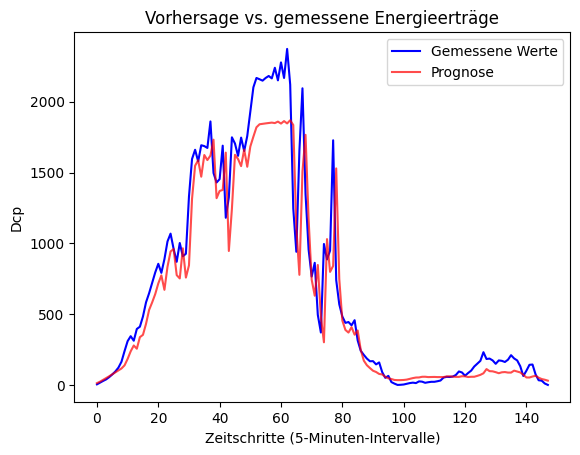

In [61]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

mask = y_true.flatten() > 0

mae_day = mean_absolute_error(y_true[mask], y_pred_inv[mask])
print('mae, model predictions {:.3f}'.format(mae_day))

#plt.figure(figsize=(12,6))
plt.plot(y_true[mask], label='Gemessene Werte', color='blue')
plt.plot(y_pred_inv[mask], label='Prognose', color='red', alpha=0.7)
plt.xlabel('Zeitschritte (5-Minuten-Intervalle)')
plt.ylabel('Dcp')
plt.title('Vorhersage vs. gemessene Energieerträge')
plt.legend()
plt.show()